In [2]:
pwd

u'/home/peter/OSCAR_mnt/rdata/EoR/Python_Scripts/BayesEoR/git_version/BayesEoR/likelihood_tests/SimpleEoRtestWQ/Jupyter'

/users/psims/Cav/EoR/Simulations_of_Reionization/HERA/Foregrounds/Diffuse_Emission/Remazeilles2015/Filtered_and_Destriped

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
(3145728,)


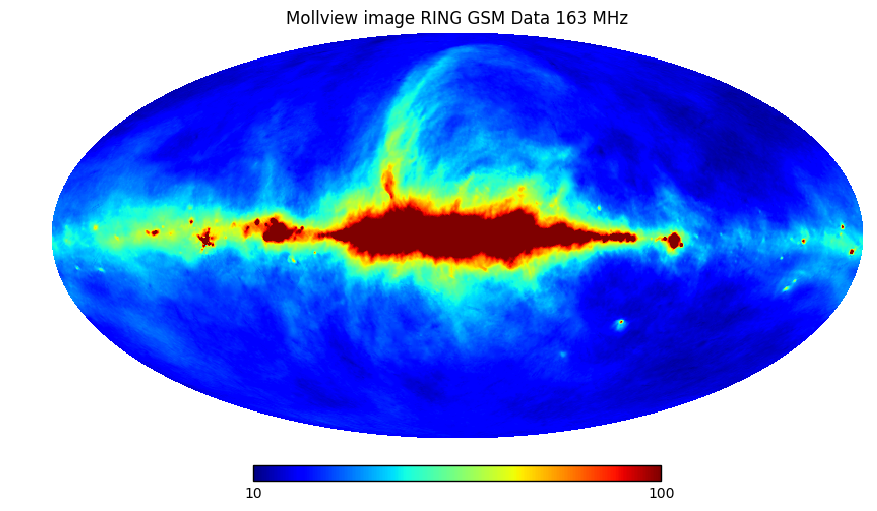

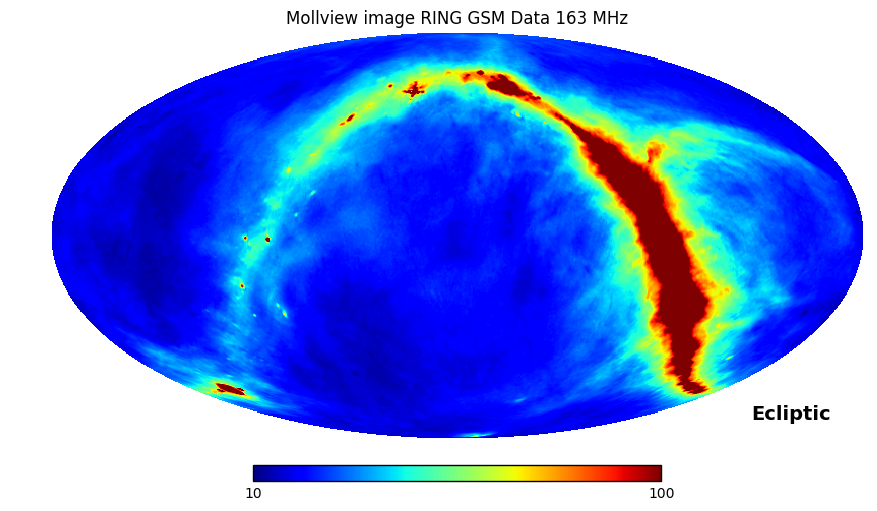

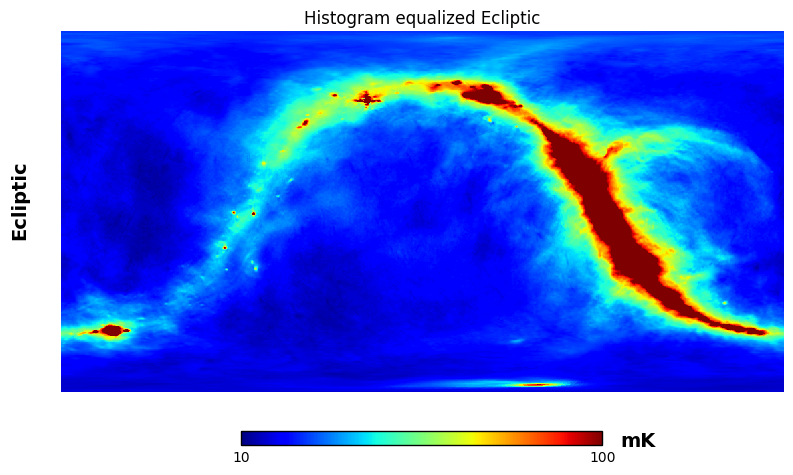

1.11.0
(541, 1081)


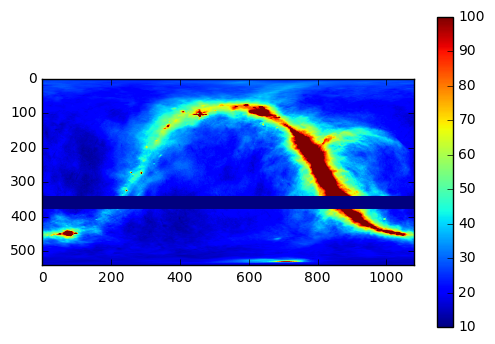

/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)
/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [3]:
import healpy as hp
import numpy as np
import astropy
from astropy.time import Time
import pygsm
import pylab
from numpy import *


###
#Read in Global Sky Model data in Galactic coordinates from file and then use it to create a healpix map and use that map to perform a cartesian projection with a Galactic coordinate to Equatorial coordinate conversion.
#Print healpix map to file.
#Print Equatorial coordinate cartesian projection of the GSM map to file
###

remazeilles_map_path = '/home/peter/OSCAR_mnt/rdata/Cav/EoR/Simulations_of_Reionization/HERA/Foregrounds/Diffuse_Emission/Remazeilles2015/Filtered_and_Destriped/'
remazeilles_map_file = 'haslam408_dsds_Remazeilles2014.fits'
remazeilles_map_path = remazeilles_map_path+remazeilles_map_file
GSM_data_remazeilles_408 = hp.fitsfunc.read_map(remazeilles_map_path)
print GSM_data_remazeilles_408.shape

hp.mollview(GSM_data_remazeilles_408, title="Mollview image RING GSM Data 163 MHz", min=10, max=100)
hp.mollview(GSM_data_remazeilles_408, coord=['G','E'], title="Mollview image RING GSM Data 163 MHz", min=10, max=100, return_projected_map=True)
pylab.show()


###
hp.pixelfunc.get_map_size(GSM_data_remazeilles_408)


xsize=1081 # resolution of the output map (larger = higher res) max resolution = 2000. 1081=1081 pixels in width -> 541 pixels width.
Cartesian_Map_Projection_Array_GSM_408=hp.visufunc.cartview(GSM_data_remazeilles_408, nest=False, coord=['G','E'], title='Histogram equalized Ecliptic', unit='mK', xsize=xsize, return_projected_map=True, min=10, max=100) #This currently doesn't work. It may require the latest version of healpy (1.7.3). Install it!!!
pylab.show()
print hp.__version__
print shape(Cartesian_Map_Projection_Array_GSM_408)


neg24deg_declination_pix = int(((90+24.)/180.)*541)
neg30deg_declination_pix = int(((90+30.)/180.)*541)
neg36deg_declination_pix = int(((90+36.)/180.)*541)

strip_height_pix = neg36deg_declination_pix - neg24deg_declination_pix

Cartesian_Map_Projection_Array_GSM_408_HERA_strip = Cartesian_Map_Projection_Array_GSM_408[::-1][neg24deg_declination_pix:neg36deg_declination_pix].copy()
Cartesian_Map_Projection_Array_GSM_225_HERA_strip = Cartesian_Map_Projection_Array_GSM_408_HERA_strip.copy()*(225./408.)**-2.7

Cartesian_Map_Projection_Array_GSM_408[::-1][neg24deg_declination_pix:neg36deg_declination_pix] = 0.0
pylab.imshow(Cartesian_Map_Projection_Array_GSM_408[::-1], vmin=10, vmax=100)
pylab.colorbar()
pylab.show()


mean_array = []
std_array = []
gc1_pix = 250
gc2_pix = 870
exclusion_region_deg = 20.0 + 6. #plus/minus 20 deg of the Galactic center + 6 deg so that the edge of the (12 deg.) field doesn't fall into the excluded region.
gc_pm20_pix = int((exclusion_region_deg/360.)*1081)

for i in range(len(Cartesian_Map_Projection_Array_GSM_225_HERA_strip[0])):
    if gc1_pix-gc_pm20_pix<i and gc1_pix+gc_pm20_pix>i or gc2_pix-gc_pm20_pix<i and gc2_pix+gc_pm20_pix>i:
        mean_array.append(np.nan)
        std_array.append(np.nan)
    else:      
        mean_array.append(np.roll(Cartesian_Map_Projection_Array_GSM_225_HERA_strip,strip_height_pix/2 - i)[:,0:36].mean())
        std_array.append(np.roll(Cartesian_Map_Projection_Array_GSM_225_HERA_strip,strip_height_pix/2 - i)[:,0:36].std())

mean_array = np.array(mean_array)
std_array = np.array(std_array)

hour_angle = np.roll(np.linspace(24.,0.,1081),-541+80)

SI_data = np.loadtxt('Data/Dexter-0.5a/Images/Mozdzen_2017_spectral_index.png.unknown')
from scipy import interpolate
f = interpolate.interp1d(SI_data[:,0], SI_data[:,1])
SI_vals = f(np.linspace(SI_data[:,0].min(), SI_data[:,0].max(),1081))
SI_vals = np.roll(SI_vals,80)
SI_vals[gc1_pix-gc_pm20_pix:gc1_pix+gc_pm20_pix] = np.nan
SI_vals[gc2_pix-gc_pm20_pix:gc2_pix+gc_pm20_pix] = np.nan

###
#Calculate x-coords pixel numbers of selected field centers
###
xcoords_field_centers = np.linspace(1,1081,1081)[10::78]
field_nan_array = np.ones(len(std_array))
#Add a 13.0/2 deg buffer region around the excluded region so the none of the field enters the excluded region
for i in range(len(std_array)):
    if np.isnan(std_array[i]):
        field_nan_array[i-40:i] = np.nan
    if np.isnan(std_array[::-1][i]):
        field_nan_array[::-1][i-40:i] = np.nan

excluded_values_mask = np.logical_not(np.isnan(field_nan_array[10::78]))
xcoords_field_centers = xcoords_field_centers[excluded_values_mask]
Alpha=0.3



# fig, ax = pylab.subplots(nrows=3, ncols=1, sharex=True)
fig, ax = pylab.subplots(nrows=4, ncols=1)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
# Plot each graph, and manually set the y tick values
cax = ax[0].imshow(Cartesian_Map_Projection_Array_GSM_225_HERA_strip, vmin=50, vmax=500)
ax[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].get_axes().set_yticks([0,36])
yt = ax[0].get_axes().get_yticks().tolist()
# yt[0]=-30.+13./2
# yt[1]=-30.-13./2
yt[0]="$-23\\degree30$'"
yt[1]="$-36\\degree30$'"
ax[0].get_axes().set_yticklabels(yt)

# ax[1].plot(hour_angle, mean_array)
ax[1].plot(np.arange(1081.), mean_array)
# axs[1].set_yticks(np.arange(0.1, 1.0, 0.2))
# axs[1].set_ylim(0, 1)
ax[1].set_xlim(0,1081)
ax[1].set_ylabel('$\\bar{T}$')
for xc in xcoords_field_centers:
    ax[1].axvline(x=xc, color='black', alpha=Alpha, linestyle='--')
ax[1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# ax[2].plot(hour_angle, std_array)
ax[2].plot(np.arange(1081.), std_array)
# axs[2].set_yticks(np.arange(-0.9, 1.0, 0.4))
# axs[2].set_ylim(-1, 1)
ax[2].set_xlim(0,1081)
for xc in xcoords_field_centers:
    ax[2].axvline(x=xc, color='black', alpha=Alpha, linestyle='--')
ax[2].set_ylabel('RMS($T$)')
ax[2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# ax[3].plot(hour_angle, std_array)
ax[3].plot(np.arange(1081.), SI_vals)
for xc in xcoords_field_centers:
    ax[3].axvline(x=xc, color='black', alpha=Alpha, linestyle='--')
ax[3].set_ylabel('$\\bar{\\beta}$')
# axs[3].set_yticks(np.arange(-0.9, 1.0, 0.4))
# axs[3].set_ylim(-1, 1)
ax[3].set_xlim(0,1081)
ax[3].set_xticks(np.linspace(0,1081,7)[1:-1])
float_xticklabels = np.round(hour_angle[np.linspace(0,1081,7)[1:-1].astype('int')],1)
text_xticklabels = ['{}h00m'.format(hr_angle) for hr_angle in float_xticklabels.astype('int')]
ax[3].set_xticklabels(text_xticklabels)
fig.savefig('Plots/HERA_strip_stats_v1d0.png')
fig.show()





jupyter_dir = '/home/peter/OSCAR_mnt/rdata/EoR/Python_Scripts/BayesEoR/git_version/BayesEoR/likelihood_tests/SimpleEoRtestWQ/Jupyter/'
np.save(jupyter_dir+'Data/HERA_strip_stats_v1d0_data', (Cartesian_Map_Projection_Array_GSM_225_HERA_strip, mean_array, std_array, SI_vals, hour_angle))







Retrieve angular coordinates corresponding to a given set of pixels and convert them from lon,lat to RA,Dec

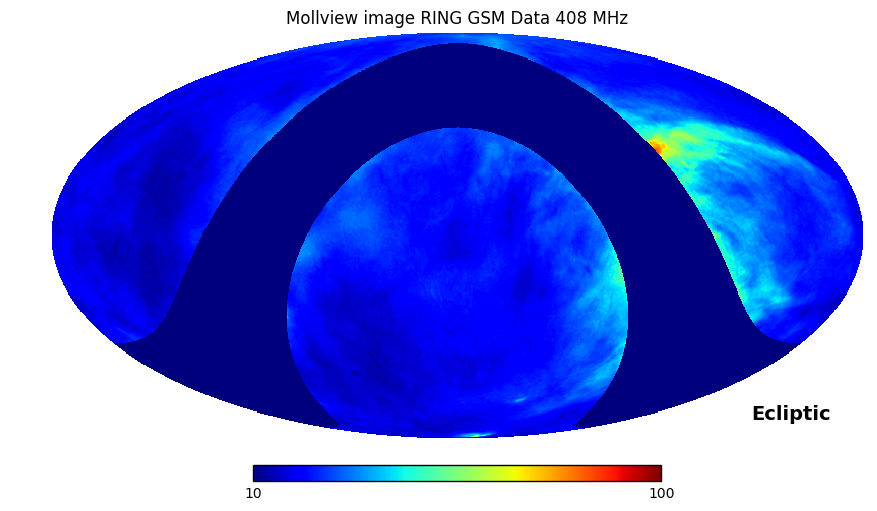

In [12]:
nside=512
lon,lat = hp.pixelfunc.pix2ang(nside,arange(GSM_data_remazeilles_408.size), lonlat=True)
lat_selector = np.logical_and(lat<0+(20.), lat>=-0-(20.))

GSM_data_remazeilles_408_Gal_latitude_selection = GSM_data_remazeilles_408.copy()
GSM_data_remazeilles_408_Gal_latitude_selection[lat_selector]=0.0
hp.mollview(GSM_data_remazeilles_408_Gal_latitude_selection, coord=['G','E'], title="Mollview image RING GSM Data 408 MHz", min=10, max=100)
pylab.show()


In [5]:
nside=512
print hp.pixelfunc.pix2ang(nside, 0, lonlat=True)
print hp.pixelfunc.pix2ang(nside, 1, lonlat=True)

lon,lat = hp.pixelfunc.pix2ang(nside,arange(GSM_data_remazeilles_408.size), lonlat=True)
print lon[0:20]
print lat.min()
print lat.max()
print lon.min()
print lon.max()

from astropy import units as u
from astropy.coordinates import SkyCoord, Galactic
print lon.shape
print lat.shape
c = SkyCoord(list(lon[:]), list(lat[:]), frame='galactic', unit="deg")
# print c
# print c.icrs
RA = np.array(c.icrs.ra)
Dec = np.array(c.icrs.dec)
# print RA
# print Dec

print RA.min()
print RA.max()
print Dec.min()
print Dec.max()

# #See: http://healpy.readthedocs.io/en/latest/generated/healpy.rotator.Rotator.html
# rotate_func = hp.rotator.Rotator(coord=['G','E'])  # Transforms galactic to ecliptic coordinates 
# RA, Dec = rotate_func(lon[0:10], lat[0:10])
# print RA*180./np.pi
# print Dec*180./np.pi

print 'hi'


(45.0, 89.908629271423436)
(135.0, 89.908629271423436)
[  45.   135.   225.   315.    22.5   67.5  112.5  157.5  202.5  247.5
  292.5  337.5   15.    45.    75.   105.   135.   165.   195.   225. ]
-89.9086292714
89.9086292714
0.0
359.912109375
(3145728,)
(3145728,)
5.98198939241e-05
359.999883593
-89.9708665836
89.9708665836
hi


Calculate the standard deviation in 12-degree regions centered on dec=-30.0

In [15]:
field_width = 12.0 #10 degrees
Dec_selector = np.logical_and(Dec<-30+(field_width/2), Dec>=-30.0-(field_width/2))
Nfields=int((RA.max()-RA.min())/field_width)
HERA_163_MHz_stds=[]
HERA_163_MHz_means=[]
for i_RA in range(Nfields):
    delta_RA = field_width
    RA_selector = np.logical_and(RA>=(i_RA*delta_RA), RA<((i_RA+1)*delta_RA))
    RA_Dec_selector_union = np.logical_and(RA_selector, Dec_selector)
    HERA_163_MHz_std = GSM_data_remazeilles_408[RA_Dec_selector_union].std()*(163./408)**-2.63
    HERA_163_MHz_mean = GSM_data_remazeilles_408[RA_Dec_selector_union].mean()*(163./408)**-2.63
    print i_RA, np.sum(RA_Dec_selector_union), HERA_163_MHz_std, HERA_163_MHz_mean
    HERA_163_MHz_stds.append(HERA_163_MHz_std)
    HERA_163_MHz_means.append(HERA_163_MHz_mean)

HERA_163_MHz_stds = np.array(HERA_163_MHz_stds)
print len(HERA_163_MHz_stds)
print sorted(HERA_163_MHz_stds)[len(HERA_163_MHz_stds)/2]
print sorted(HERA_163_MHz_stds)[int(len(HERA_163_MHz_stds)*35./100)]
print np.mean(sorted(HERA_163_MHz_stds)[-8:])
print 25, HERA_163_MHz_stds[25], HERA_163_MHz_means[25]
print 24,HERA_163_MHz_stds[24], HERA_163_MHz_means[24] 


0 9492 9.55572240655 231.589052643
1 9500 7.99748339439 222.329146361
2 9487 7.7644032814 213.753948434
3 9488 7.9672412187 185.821847085
4 9490 10.9414528178 165.630929036
5 9492 12.4384511505 168.708919552
6 9495 11.2567641414 173.320609337
7 9494 12.3894654348 184.184742345
8 9487 35.1660707416 249.609559337
9 9493 38.7473432042 342.174822576
10 9490 42.0415702486 327.22005278
11 9494 67.7523765862 295.470781121
12 9488 59.3769060109 274.755222452
13 9496 17.8629446724 210.965841527
14 9487 27.7668577854 211.466346457
15 9488 33.4588995163 251.494105028
16 9484 64.6769681633 345.824902834
17 9492 45.2824605646 398.880747518
18 9495 44.0818380357 414.338546345
19 9488 66.0349371277 512.88997502
20 9490 121.766980948 686.154851355
21 9492 1170.82552144 1737.93598956
22 9490 2203.76349745 2712.80658515
23 9492 182.612779854 746.450526028
24 9493 67.0332531202 470.671694762
25 9495 28.652171727 324.540907867
26 9491 17.5243187647 291.976210374
27 9493 20.7607425841 219.758569697
28 9481

Select a range of regions of interest

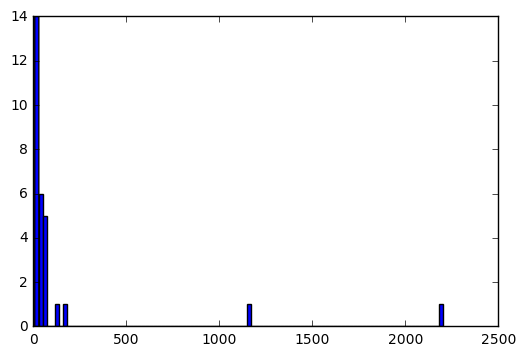

7.7644032814 59.3769060109
(array([2]),) (array([12]),)


In [7]:
import pylab as P
P.close('all')
P.hist(HERA_163_MHz_stds, bins=100)
P.show()

Cut_value_0th_percentile = np.percentile(HERA_163_MHz_stds, 0, interpolation='nearest')
Cut_value_70th_percentile = np.percentile(HERA_163_MHz_stds, 70, interpolation='nearest')
print Cut_value_0th_percentile, Cut_value_70th_percentile
region_0th_percentile = np.where(HERA_163_MHz_stds == Cut_value_0th_percentile)
region_70th_percentile = np.where(HERA_163_MHz_stds == Cut_value_70th_percentile)
print region_0th_percentile, region_70th_percentile

In [8]:
print np.percentile(HERA_163_MHz_stds, 45, interpolation='nearest')

28.652171727


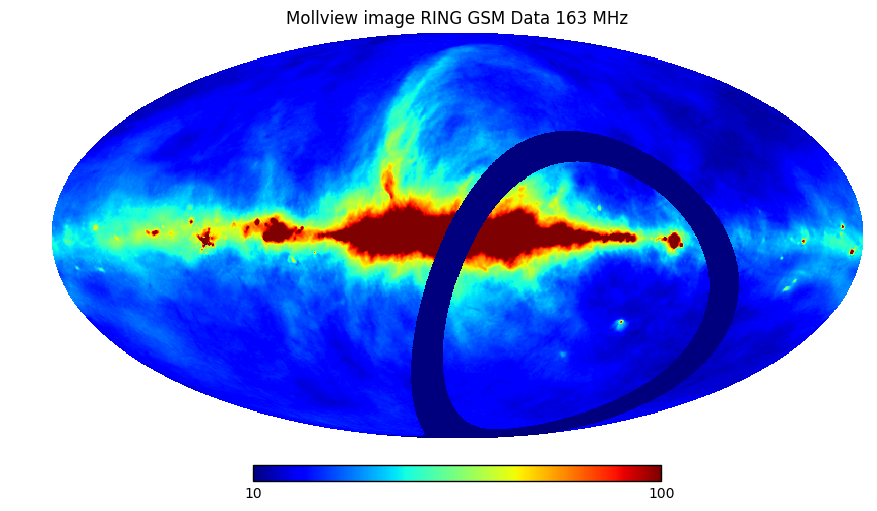

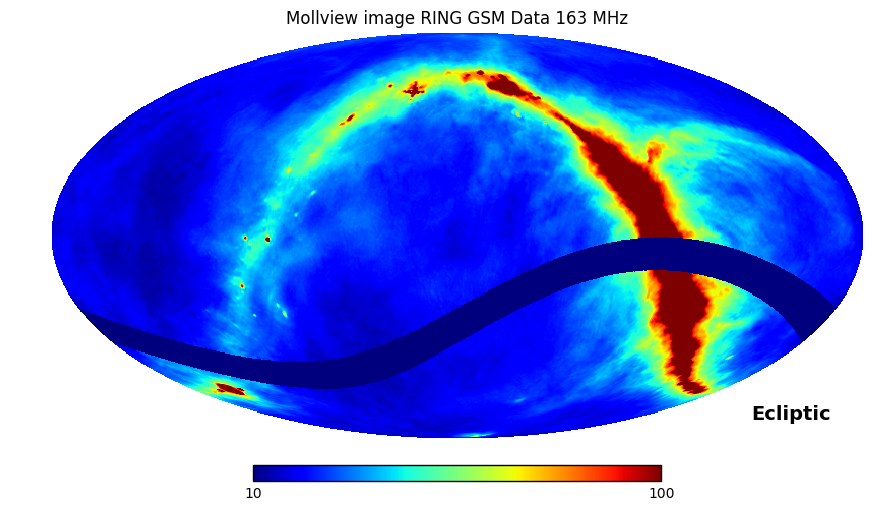

In [9]:
GSM_data_remazeilles_408_latitude_selection = GSM_data_remazeilles_408.copy()
GSM_data_remazeilles_408_latitude_selection[Dec_selector]=0.0
# hp.mollview(GSM_data_remazeilles_408, title="Mollview image RING GSM Data 163 MHz", min=10, max=100)
hp.mollview(GSM_data_remazeilles_408_latitude_selection, title="Mollview image RING GSM Data 163 MHz", min=10, max=100)
hp.mollview(GSM_data_remazeilles_408_latitude_selection, coord=['G','E'], title="Mollview image RING GSM Data 163 MHz", min=10, max=100)
pylab.show()


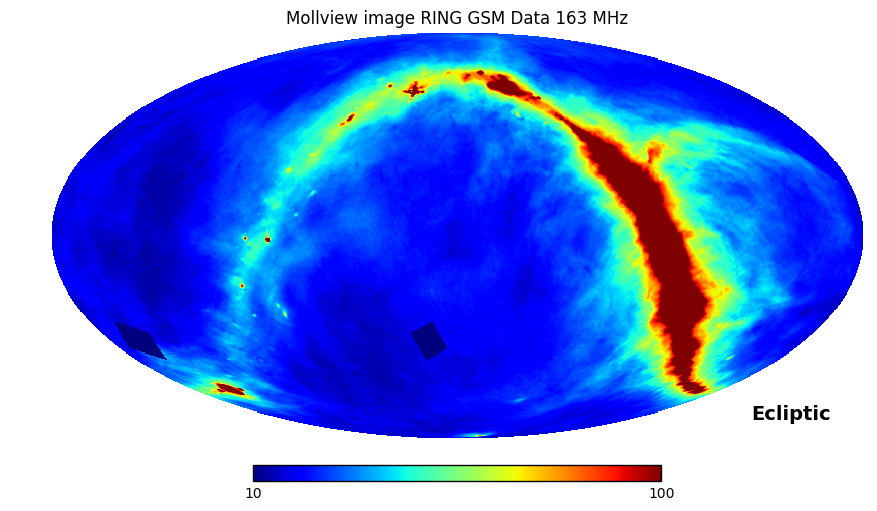

In [10]:
RA_selector_region_0th_percentile = np.logical_and(RA>=(region_0th_percentile[0]*delta_RA), RA<((region_0th_percentile[0]+1)*delta_RA))
RA_selector_region_70th_percentile = np.logical_and(RA>=(region_70th_percentile[0]*delta_RA), RA<((region_70th_percentile[0]+1)*delta_RA))

GSM_data_remazeilles_408_region_70th_percentile = GSM_data_remazeilles_408.copy()
GSM_data_remazeilles_408_region_70th_percentile[np.logical_and(Dec_selector, RA_selector_region_70th_percentile)]=0.0
GSM_data_remazeilles_408_region_70th_percentile[np.logical_and(Dec_selector, RA_selector_region_0th_percentile)]=0.0
# hp.mollview(GSM_data_remazeilles_408, title="Mollview image RING GSM Data 163 MHz", min=10, max=100)
hp.mollview(GSM_data_remazeilles_408_region_70th_percentile, coord=['G','E'], title="Mollview image RING GSM Data 163 MHz", min=10, max=100)
pylab.show()


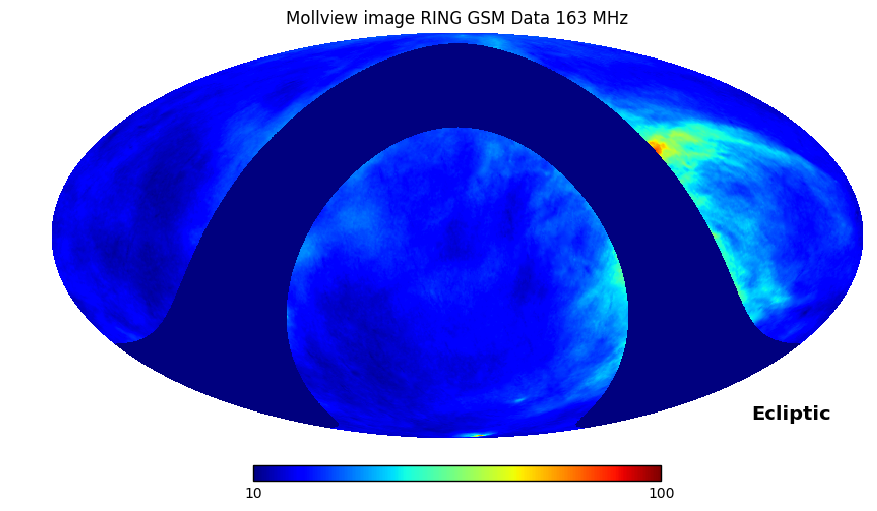

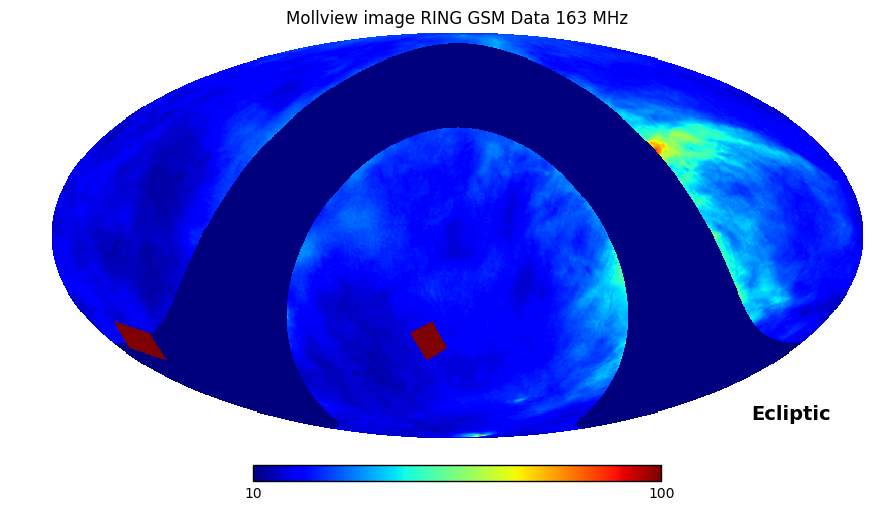

In [11]:
lon,lat = hp.pixelfunc.pix2ang(nside,arange(GSM_data_remazeilles_408.size), lonlat=True)
lat_selector = np.logical_and(lat<0+(20.), lat>=-0-(20.))

GSM_data_remazeilles_408_Gal_latitude_selection = GSM_data_remazeilles_408.copy()
GSM_data_remazeilles_408_Gal_latitude_selection[lat_selector]=0.0
hp.mollview(GSM_data_remazeilles_408_Gal_latitude_selection, coord=['G','E'], title="Mollview image RING GSM Data 163 MHz", min=10, max=100)
pylab.show()


GSM_data_remazeilles_408_Gal_latitude_selection[np.logical_and(Dec_selector, RA_selector_region_70th_percentile)]=100.0
GSM_data_remazeilles_408_Gal_latitude_selection[np.logical_and(Dec_selector, RA_selector_region_0th_percentile)]=100.0
# hp.mollview(GSM_data_remazeilles_408, title="Mollview image RING GSM Data 163 MHz", min=10, max=100)
hp.mollview(GSM_data_remazeilles_408_Gal_latitude_selection, coord=['G','E'], title="Mollview image RING GSM Data 163 MHz", min=10, max=100)
pylab.show()






